In [163]:
from PIL import Image
from numpy import *
import random as rand
from matplotlib import pyplot as plt

In [164]:
img = Image.open("beach.jpeg")
width, height = img.size

In [165]:
def grayscale(img_data):
    return dot(img_data[...,:3], [0.21, 0.72, 0.07])

def initialize_centers(k):
    centers = empty([k,3], dtype=int)
    for i in range(k):
        y = rand.randint(0, left_half.shape[0]-1)
        x = rand.randint(0, left_half.shape[1]-1)
        centers[i] = left_half[y,x]
    return centers

def distance(center, point):
    return sqrt(2*(center[0] - point[0])**2 + 4*(center[1] - point[1])**2 + 3*(center[2] - point[2])**2)

def cluster_with(centers, k):
    classes = empty([left_half.shape[0], left_half.shape[1], 1], dtype=int)
    for y in range(left_half.shape[0]):
        for x in range(left_half.shape[1]):
            minimum = distance(centers[0], left_half[y,x])
            classes[y,x] = 0;
            for i in range(1,k):
                if(distance(centers[i], left_half[y,x]) < minimum):
                    minimum = distance(centers[i], left_half[y,x])
                    classes[y,x] = i;
    return classes

def find_new_centers(centers, classes,k):
    # count the number of pixels per cluster, and su
    cluster_counts = zeros((k,1), dtype=int)
    for y in range(left_half.shape[0]):
        for x in range(left_half.shape[1]):
            cluster_counts[classes[y,x,0], 0] = cluster_counts[classes[y,x,0], 0] + 1
            centers[classes[y,x,0]] = centers[classes[y,x,0]] + left_half[y,x]
    return cluster_counts, centers

def kmeans(k):
    # initialize cluster centers (random RGB colors)
    centers = initialize_centers(k)
    iteration = 0
    while(1):
        iteration = iteration + 1
        print("Starting iteration ",iteration)
        # cluster each pixel with each of the centers
        #print("---classifying centers")
        prev_centers = centers.copy()
        classes = cluster_with(centers, k)
        # keep track of current centers
        # search for new centers
        #print("---searching for new centers")
        cluster_counts, centers = find_new_centers(centers, classes, k)
        if 0 in cluster_counts:
            # bad initial centers, re-roll
            centers = initialize_centers(k)
            print("Bad centers, reinitializing.")
            iteration = 0
        else:
            # find means of each center -> equal new centers
            centers = centers//cluster_counts
            if ((centers == prev_centers).all()):
                return centers, classes

In [167]:
data = asarray(img.getdata())
image_array = data.reshape(height,width, 3)
k = 5

# Original Image

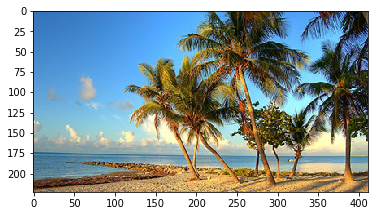

In [206]:
plt.imshow(image_array)

# The Grayscaled Image

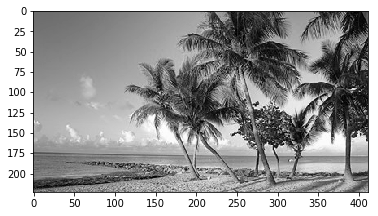

In [207]:
gray_img = grayscale(image_array)
plt.imshow(gray_img, cmap='gray')

In [209]:
gray_left = gray_img[:,:width//2]
gray_right = gray_img[:,width//2:]
left_half = image_array[:, :width//2, :]

# Run K-means on left half to grab (k = 5) colors

In [172]:
colors, pixel_classes = kmeans(k)

Starting iteration  1
Starting iteration  2
Starting iteration  3
Starting iteration  4
Starting iteration  5
Starting iteration  6
Starting iteration  7
Starting iteration  8
Starting iteration  9
Starting iteration  10
Starting iteration  11
Starting iteration  12
Starting iteration  13
Starting iteration  14
Starting iteration  15
Starting iteration  16
Starting iteration  17
Starting iteration  18
Starting iteration  19


### Found Colors

In [173]:
colors

array([[175, 140,  83],
       [176, 197, 190],
       [ 81, 134, 179],
       [ 91,  65,  27],
       [ 93, 169, 233]], dtype=int32)

### Left half re-colored with the k=5 colors

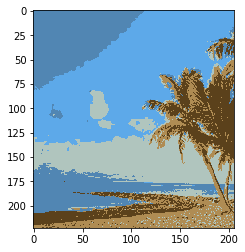

In [174]:
new_left_half = left_half.copy()
for y in range(left_half.shape[0]):
    for x in range(left_half.shape[1]):
        new_left_half[y,x] = colors[pixel_classes[y,x,0]]
plt.imshow(new_left_half)

In [210]:
colored_left = new_left_half.reshape((new_left_half.shape[0]*new_left_half.shape[1],3))

# Multiclass Logistic Regression using Softmax

In [211]:
def initialize_weights(k):
    return zeros((2,k), dtype=int)

def one_hot_encode(color_image, colors, k):
    labels = zeros((color_image.shape[0],k))
    for i in range(color_image.shape[0]):
        for j in range(k):
            if(color_image[i] == colors[j]).all():
                labels[i, j] = 1
    return labels

def cross_entropy_loss(pred, label):
    return sum(-1 * label * log(pred), axis=1)
def softmax(z):
    #print(x)
    #print(w)
    return exp(z)/(sum(exp(z), axis=1).reshape(z.shape[0],1))

def gradient(x,y,w,alpha):
    #print((softmax(x,w) - y))
    #print(alpha*x.T.dot((softmax(x.dot(w)) - y)))
    return alpha*x.T.dot((softmax(x.dot(w)) - y))
    #return alpha*x.T.dot((y - softmax(x,w)))
def gradient_descent(x,y,w,alpha):
    w = w - gradient(x,y,w,alpha)
    prob = softmax(x.dot(w))
    #print(prob)
    predictions = zeros(y.shape)
    #print(prob)
    for j in range(x.shape[0]):
        max_index = argmax(prob[j])
        predictions[j,max_index] = 1
    return w, predictions

def train(gray_image, labels, k):
    height = gray_image.shape[0]
    width = gray_image.shape[1]
    gray_image = gray_image.reshape((height*width, 1))
    gray_image = gray_image/255
    gray_image = concatenate((gray_image, ones((height*width, 1))), axis=1)
    weights = initialize_weights(k)
    # weights: 2 x k  data: n x 2
    for i in range(1500):
        #c = list(zip(gray_image, labels))
        #random.shuffle(c)
        #gray_image, labels = zip(*c)
        #gray_image = array(gray_image)
        #labels = array(labels)
        print("Iteration:",i)
        weights, predictions = gradient_descent(gray_image,labels,weights,0.00001)
        #print(predictions)
        accuracy = round(sum((sum((predictions==labels), axis=1) == k))/ predictions.shape[0]*100, 3)
        print("---Accuracy: ", accuracy,"%")
        print("---Loss: ", sum(cross_entropy_loss(softmax(gray_image.dot(weights)), labels)))
    #print(gray_image)
    return weights

def recolor(gray_image, weights, colors, k):
    height = gray_image.shape[0]
    width = gray_image.shape[1]
    colored_image =  zeros((height, width, 3), dtype=int)
    gray_image = gray_image.reshape((height*width, 1))
    gray_image = gray_image/255
    gray_image = concatenate((gray_image, ones((height*width, 1))), axis=1)
    probabilities = softmax(gray_image.dot(weights)).reshape((height, width, k))
    for y in range(height):
        for x in range(width):
            color_index = argmax(probabilities[y,x])
            colored_image[y,x] = colors[color_index]
    plt.imshow(colored_image)

### Train Models using left half of grayed image

In [205]:
labels = one_hot_encode(colored_left, colors, k)
weights = train(gray_left, labels, k)

Iteration: 0
---Accuracy:  32.881 %
---Loss:  73002.72704802454
Iteration: 1
---Accuracy:  32.881 %
---Loss:  72275.80267132515
Iteration: 2
---Accuracy:  32.881 %
---Loss:  71708.58778687553
Iteration: 3
---Accuracy:  32.881 %
---Loss:  71264.58177024042
Iteration: 4
---Accuracy:  32.881 %
---Loss:  70914.76423762037
Iteration: 5
---Accuracy:  32.881 %
---Loss:  70636.46758610226
Iteration: 6
---Accuracy:  32.881 %
---Loss:  70412.2462720171
Iteration: 7
---Accuracy:  32.881 %
---Loss:  70228.82940370972
Iteration: 8
---Accuracy:  32.881 %
---Loss:  70076.20816417728
Iteration: 9
---Accuracy:  32.881 %
---Loss:  69946.8771654159
Iteration: 10
---Accuracy:  32.881 %
---Loss:  69835.22599242436
Iteration: 11
---Accuracy:  32.881 %
---Loss:  69737.06434807957
Iteration: 12
---Accuracy:  32.881 %
---Loss:  69649.25902102087
Iteration: 13
---Accuracy:  32.881 %
---Loss:  69569.46055471274
Iteration: 14
---Accuracy:  32.881 %
---Loss:  69495.89970636944
Iteration: 15
---Accuracy:  32.881 %


---Accuracy:  32.881 %
---Loss:  64605.72421035218
Iteration: 129
---Accuracy:  32.881 %
---Loss:  64570.46299212573
Iteration: 130
---Accuracy:  32.881 %
---Loss:  64535.30228969877
Iteration: 131
---Accuracy:  32.881 %
---Loss:  64500.241713778065
Iteration: 132
---Accuracy:  32.881 %
---Loss:  64465.280876453704
Iteration: 133
---Accuracy:  32.881 %
---Loss:  64430.41939119976
Iteration: 134
---Accuracy:  32.881 %
---Loss:  64395.65687287486
Iteration: 135
---Accuracy:  32.894 %
---Loss:  64360.99293772272
Iteration: 136
---Accuracy:  32.901 %
---Loss:  64326.42720337252
Iteration: 137
---Accuracy:  32.914 %
---Loss:  64291.95928883913
Iteration: 138
---Accuracy:  32.931 %
---Loss:  64257.58881452328
Iteration: 139
---Accuracy:  32.944 %
---Loss:  64223.315402211694
Iteration: 140
---Accuracy:  32.966 %
---Loss:  64189.13867507699
Iteration: 141
---Accuracy:  32.984 %
---Loss:  64155.058257677534
Iteration: 142
---Accuracy:  32.99 %
---Loss:  64121.073775957295
Iteration: 143
---Acc

---Loss:  60866.54758619511
Iteration: 254
---Accuracy:  37.681 %
---Loss:  60841.2613515694
Iteration: 255
---Accuracy:  37.744 %
---Loss:  60816.03718718299
Iteration: 256
---Accuracy:  37.792 %
---Loss:  60790.8748605225
Iteration: 257
---Accuracy:  37.858 %
---Loss:  60765.77414010289
Iteration: 258
---Accuracy:  37.927 %
---Loss:  60740.734795463315
Iteration: 259
---Accuracy:  37.999 %
---Loss:  60715.75659716298
Iteration: 260
---Accuracy:  38.058 %
---Loss:  60690.83931677699
Iteration: 261
---Accuracy:  38.112 %
---Loss:  60665.98272689222
Iteration: 262
---Accuracy:  38.149 %
---Loss:  60641.186601103196
Iteration: 263
---Accuracy:  38.208 %
---Loss:  60616.45071400791
Iteration: 264
---Accuracy:  38.265 %
---Loss:  60591.77484120372
Iteration: 265
---Accuracy:  38.304 %
---Loss:  60567.158759283266
Iteration: 266
---Accuracy:  38.339 %
---Loss:  60542.60224583026
Iteration: 267
---Accuracy:  38.391 %
---Loss:  60518.105079415436
Iteration: 268
---Accuracy:  38.454 %
---Loss:

---Accuracy:  44.203 %
---Loss:  58121.95305960097
Iteration: 379
---Accuracy:  44.255 %
---Loss:  58102.91171419101
Iteration: 380
---Accuracy:  44.284 %
---Loss:  58083.910095784675
Iteration: 381
---Accuracy:  44.34 %
---Loss:  58064.94807079538
Iteration: 382
---Accuracy:  44.368 %
---Loss:  58046.02550621669
Iteration: 383
---Accuracy:  44.401 %
---Loss:  58027.14226961959
Iteration: 384
---Accuracy:  44.469 %
---Loss:  58008.29822914957
Iteration: 385
---Accuracy:  44.534 %
---Loss:  57989.493253523964
Iteration: 386
---Accuracy:  44.577 %
---Loss:  57970.72721202904
Iteration: 387
---Accuracy:  44.606 %
---Loss:  57951.99997451734
Iteration: 388
---Accuracy:  44.651 %
---Loss:  57933.311411404866
Iteration: 389
---Accuracy:  44.682 %
---Loss:  57914.661393668335
Iteration: 390
---Accuracy:  44.797 %
---Loss:  57896.04979284252
Iteration: 391
---Accuracy:  44.839 %
---Loss:  57877.47648101747
Iteration: 392
---Accuracy:  44.887 %
---Loss:  57858.94133083583
Iteration: 393
---Accu

---Accuracy:  50.372 %
---Loss:  56012.24179043615
Iteration: 504
---Accuracy:  50.398 %
---Loss:  55997.29093253619
Iteration: 505
---Accuracy:  50.42 %
---Loss:  55982.36682101109
Iteration: 506
---Accuracy:  50.52 %
---Loss:  55967.46937670075
Iteration: 507
---Accuracy:  50.544 %
---Loss:  55952.598520760934
Iteration: 508
---Accuracy:  50.586 %
---Loss:  55937.754174661735
Iteration: 509
---Accuracy:  50.605 %
---Loss:  55922.93626018612
Iteration: 510
---Accuracy:  50.662 %
---Loss:  55908.14469942836
Iteration: 511
---Accuracy:  50.677 %
---Loss:  55893.37941479266
Iteration: 512
---Accuracy:  50.86 %
---Loss:  55878.640328991554
Iteration: 513
---Accuracy:  50.895 %
---Loss:  55863.92736504451
Iteration: 514
---Accuracy:  50.94 %
---Loss:  55849.240446276475
Iteration: 515
---Accuracy:  50.962 %
---Loss:  55834.579496316386
Iteration: 516
---Accuracy:  50.984 %
---Loss:  55819.9444390957
Iteration: 517
---Accuracy:  51.027 %
---Loss:  55805.335198847046
Iteration: 518
---Accura

---Accuracy:  55.192 %
---Loss:  54340.409417102
Iteration: 628
---Accuracy:  55.211 %
---Loss:  54328.25683448772
Iteration: 629
---Accuracy:  55.233 %
---Loss:  54316.12318852763
Iteration: 630
---Accuracy:  55.248 %
---Loss:  54304.008429816895
Iteration: 631
---Accuracy:  55.261 %
---Loss:  54291.91250912848
Iteration: 632
---Accuracy:  55.27 %
---Loss:  54279.83537741223
Iteration: 633
---Accuracy:  55.281 %
---Loss:  54267.776985794175
Iteration: 634
---Accuracy:  55.301 %
---Loss:  54255.73728557569
Iteration: 635
---Accuracy:  55.32 %
---Loss:  54243.71622823275
Iteration: 636
---Accuracy:  55.331 %
---Loss:  54231.71376541515
Iteration: 637
---Accuracy:  55.403 %
---Loss:  54219.7298489457
Iteration: 638
---Accuracy:  55.42 %
---Loss:  54207.76443081951
Iteration: 639
---Accuracy:  55.468 %
---Loss:  54195.817463203166
Iteration: 640
---Accuracy:  55.494 %
---Loss:  54183.888898434045
Iteration: 641
---Accuracy:  55.51 %
---Loss:  54171.978689019474
Iteration: 642
---Accuracy:

---Loss:  52964.08411600413
Iteration: 752
---Accuracy:  58.381 %
---Loss:  52953.95143049325
Iteration: 753
---Accuracy:  58.387 %
---Loss:  52943.832698795035
Iteration: 754
---Accuracy:  58.405 %
---Loss:  52933.7278885784
Iteration: 755
---Accuracy:  58.42 %
---Loss:  52923.63696761688
Iteration: 756
---Accuracy:  58.433 %
---Loss:  52913.559903788104
Iteration: 757
---Accuracy:  58.446 %
---Loss:  52903.49666507347
Iteration: 758
---Accuracy:  58.657 %
---Loss:  52893.44721955761
Iteration: 759
---Accuracy:  58.664 %
---Loss:  52883.41153542808
Iteration: 760
---Accuracy:  58.677 %
---Loss:  52873.389580974865
Iteration: 761
---Accuracy:  58.692 %
---Loss:  52863.38132459
Iteration: 762
---Accuracy:  58.747 %
---Loss:  52853.386734767126
Iteration: 763
---Accuracy:  58.771 %
---Loss:  52843.405780101144
Iteration: 764
---Accuracy:  58.792 %
---Loss:  52833.43842928771
Iteration: 765
---Accuracy:  58.814 %
---Loss:  52823.48465112289
Iteration: 766
---Accuracy:  58.89 %
---Loss:  5

---Accuracy:  60.876 %
---Loss:  51796.28946359843
Iteration: 877
---Accuracy:  60.891 %
---Loss:  51787.679965706906
Iteration: 878
---Accuracy:  60.897 %
---Loss:  51779.08107267888
Iteration: 879
---Accuracy:  60.936 %
---Loss:  51770.492762506845
Iteration: 880
---Accuracy:  60.936 %
---Loss:  51761.915013247475
Iteration: 881
---Accuracy:  60.945 %
---Loss:  51753.34780302136
Iteration: 882
---Accuracy:  60.952 %
---Loss:  51744.79111001283
Iteration: 883
---Accuracy:  60.958 %
---Loss:  51736.24491246967
Iteration: 884
---Accuracy:  60.958 %
---Loss:  51727.709188702895
Iteration: 885
---Accuracy:  60.967 %
---Loss:  51719.18391708653
Iteration: 886
---Accuracy:  60.978 %
---Loss:  51710.66907605733
Iteration: 887
---Accuracy:  60.997 %
---Loss:  51702.164644114644
Iteration: 888
---Accuracy:  61.013 %
---Loss:  51693.67059982005
Iteration: 889
---Accuracy:  61.017 %
---Loss:  51685.18692179724
Iteration: 890
---Accuracy:  61.037 %
---Loss:  51676.713588731756
Iteration: 891
---A

---Accuracy:  62.743 %
---Loss:  50795.867652032575
Iteration: 1002
---Accuracy:  62.748 %
---Loss:  50788.43151072727
Iteration: 1003
---Accuracy:  62.763 %
---Loss:  50781.0036540826
Iteration: 1004
---Accuracy:  62.772 %
---Loss:  50773.584066555886
Iteration: 1005
---Accuracy:  62.782 %
---Loss:  50766.172732645595
Iteration: 1006
---Accuracy:  62.791 %
---Loss:  50758.76963689115
Iteration: 1007
---Accuracy:  62.791 %
---Loss:  50751.37476387285
Iteration: 1008
---Accuracy:  62.804 %
---Loss:  50743.98809821165
Iteration: 1009
---Accuracy:  62.806 %
---Loss:  50736.60962456916
Iteration: 1010
---Accuracy:  62.815 %
---Loss:  50729.23932764734
Iteration: 1011
---Accuracy:  62.815 %
---Loss:  50721.8771921885
Iteration: 1012
---Accuracy:  62.867 %
---Loss:  50714.52320297507
Iteration: 1013
---Accuracy:  62.874 %
---Loss:  50707.17734482957
Iteration: 1014
---Accuracy:  62.874 %
---Loss:  50699.83960261433
Iteration: 1015
---Accuracy:  62.878 %
---Loss:  50692.50996123151
Iteration:

---Accuracy:  64.073 %
---Loss:  49932.501545621504
Iteration: 1126
---Accuracy:  64.078 %
---Loss:  49925.98573616346
Iteration: 1127
---Accuracy:  64.086 %
---Loss:  49919.47655922876
Iteration: 1128
---Accuracy:  64.089 %
---Loss:  49912.974003464864
Iteration: 1129
---Accuracy:  64.102 %
---Loss:  49906.478057546665
Iteration: 1130
---Accuracy:  64.108 %
---Loss:  49899.988710176425
Iteration: 1131
---Accuracy:  64.154 %
---Loss:  49893.5059500837
Iteration: 1132
---Accuracy:  64.152 %
---Loss:  49887.029766025276
Iteration: 1133
---Accuracy:  64.152 %
---Loss:  49880.56014678501
Iteration: 1134
---Accuracy:  64.152 %
---Loss:  49874.09708117383
Iteration: 1135
---Accuracy:  64.16 %
---Loss:  49867.6405580296
Iteration: 1136
---Accuracy:  64.163 %
---Loss:  49861.19056621707
Iteration: 1137
---Accuracy:  64.176 %
---Loss:  49854.74709462776
Iteration: 1138
---Accuracy:  64.18 %
---Loss:  49848.31013217988
Iteration: 1139
---Accuracy:  64.187 %
---Loss:  49841.8796678183
Iteration: 

---Accuracy:  65.094 %
---Loss:  49177.6173840845
Iteration: 1249
---Accuracy:  65.112 %
---Loss:  49171.83979470256
Iteration: 1250
---Accuracy:  65.114 %
---Loss:  49166.06762429178
Iteration: 1251
---Accuracy:  65.118 %
---Loss:  49160.300864322024
Iteration: 1252
---Accuracy:  65.136 %
---Loss:  49154.53950628205
Iteration: 1253
---Accuracy:  65.138 %
---Loss:  49148.783541679666
Iteration: 1254
---Accuracy:  65.138 %
---Loss:  49143.032962041485
Iteration: 1255
---Accuracy:  65.136 %
---Loss:  49137.287758913015
Iteration: 1256
---Accuracy:  65.151 %
---Loss:  49131.54792385849
Iteration: 1257
---Accuracy:  65.16 %
---Loss:  49125.813448460925
Iteration: 1258
---Accuracy:  65.16 %
---Loss:  49120.08432432195
Iteration: 1259
---Accuracy:  65.166 %
---Loss:  49114.36054306186
Iteration: 1260
---Accuracy:  65.162 %
---Loss:  49108.642096319476
Iteration: 1261
---Accuracy:  65.164 %
---Loss:  49102.92897575216
Iteration: 1262
---Accuracy:  65.177 %
---Loss:  49097.22117303573
Iteratio

---Accuracy:  65.958 %
---Loss:  48510.386718348
Iteration: 1371
---Accuracy:  65.98 %
---Loss:  48505.21244800738
Iteration: 1372
---Accuracy:  65.987 %
---Loss:  48500.04268158599
Iteration: 1373
---Accuracy:  65.993 %
---Loss:  48494.87741251863
Iteration: 1374
---Accuracy:  65.995 %
---Loss:  48489.716634253695
Iteration: 1375
---Accuracy:  66.002 %
---Loss:  48484.56034025306
Iteration: 1376
---Accuracy:  66.002 %
---Loss:  48479.408523992075
Iteration: 1377
---Accuracy:  66.006 %
---Loss:  48474.26117895954
Iteration: 1378
---Accuracy:  66.011 %
---Loss:  48469.11829865765
Iteration: 1379
---Accuracy:  66.011 %
---Loss:  48463.97987660197
Iteration: 1380
---Accuracy:  66.015 %
---Loss:  48458.8459063214
Iteration: 1381
---Accuracy:  66.015 %
---Loss:  48453.716381358136
Iteration: 1382
---Accuracy:  66.015 %
---Loss:  48448.59129526763
Iteration: 1383
---Accuracy:  65.985 %
---Loss:  48443.47064161858
Iteration: 1384
---Accuracy:  65.991 %
---Loss:  48438.354413992834
Iteration: 

---Accuracy:  66.605 %
---Loss:  47901.207517575414
Iteration: 1495
---Accuracy:  66.614 %
---Loss:  47896.545554342156
Iteration: 1496
---Accuracy:  66.614 %
---Loss:  47891.887374069265
Iteration: 1497
---Accuracy:  66.616 %
---Loss:  47887.23297162872
Iteration: 1498
---Accuracy:  66.616 %
---Loss:  47882.58234190234
Iteration: 1499
---Accuracy:  66.62 %
---Loss:  47877.9354797818


### Recolored right half image using model

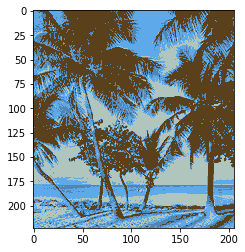

In [188]:
recolor(gray_right, weights, colors, k)